In [26]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention, 
    Reshape, Flatten, Concatenate, Activation, Add, Input
)
from tensorflow.keras.models import Model  
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.activations import gelu

from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import torch
import fitz
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from typing import List, Tuple

In [27]:
class TextProcessorWithPyMuPDF:
    def __init__(self, max_length=1024):
        self.model_name = "sentence-transformers/all-MiniLM-L6-v2"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        # Correctly initialize the sentence transformer
        self.sentence_transformer = SentenceTransformer(self.model_name)
        self.max_length = max_length
    
    def extract_from_pdf(self, pdf_path: str) -> str:
        """Extract text from PDF using PyMuPDF"""
        text = ""
        try:
            with fitz.open(pdf_path) as doc:
                for page in doc:
                    text += page.get_text() + "\n"
        except Exception as e:
            print(f"Error processing {pdf_path}: {str(e)}")
            return ""
        return text

    def clean_text(self, text: str) -> str:
        """Clean and normalize text"""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n+', ' ', text)
        text = re.sub(r'[^\w\s\-\'àáâãäåèéêëìíîïòóôõöùúûüýÿÀÁÂÃÄÅÈÉÊËÌÍÎÏÒÓÔÕÖÙÚÛÜÝ]', '', text)
        return text.strip()
    
    def hapus_duplikat(self, text: str) -> str:
        seen = set()
        result_text = []
        lines = text.split("\n")
        for line in lines:
            cleaned_line = line.strip()
            if cleaned_line and cleaned_line not in seen:
                seen.add(cleaned_line)
                result_text.append(cleaned_line)
        return "\n".join(result_text)
    
    def cut_isi(self, text: str) -> str:
        pola_2dapus = re.compile(r'(?<=daftar pustaka)(.*?)(?=daftar pustaka)', re.IGNORECASE)
        match = pola_2dapus.search(text)
        if match:
            hasil = match.group(1)
            return hasil
        else:
            pola_1dapus = re.compile(r'(.*?)(daftar pustaka)', re.IGNORECASE)
            cek_1dapus = pola_1dapus.search(text)
            if cek_1dapus:
                hasil = cek_1dapus.group(1)
                return hasil
            else:
                return "Tidak ditemukan kata 'daftar pustaka' sama sekali."

    def cut_daftar(self, text: str) -> str:
        pola_titik = re.compile(r'\.{10,}', re.DOTALL)
        matches = list(pola_titik.finditer(text))
        if matches:
            last_match = matches[-1]
            last_match_end = last_match.end()
            text = text[last_match_end:].strip()
        return text
    
    def generate_embeddings(self, texts, batch_size=32):
        """Generate embeddings for texts"""
        embeddings_list = []
        # Ensure texts is a list
        if isinstance(texts, str):
            texts = [texts]
        
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            # Use encode method from sentence_transformer
            batch_embeddings = self.sentence_transformer.encode(batch, convert_to_tensor=True)
            embeddings_list.append(batch_embeddings)
        
        return torch.cat(embeddings_list, dim=0)
 
    def augment_text_methods(self, text: str) -> List[str]:
        """Text augmentation methods"""
        augmented = []
        
        # 1. Sentence shuffling
        sentences = text.split('. ')
        if len(sentences) > 1:
            shuffled = sentences.copy()
            np.random.shuffle(shuffled)
            augmented.append('. '.join(shuffled))
        
        # 2. Random deletion
        words = text.split()
        if len(words) > 10:
            n_to_delete = max(1, int(len(words) * 0.1))
            keep_indices = np.random.choice(
                len(words), 
                len(words) - n_to_delete, 
                replace=False
            )
            augmented.append(' '.join([words[i] for i in sorted(keep_indices)]))
            
        # 3. Random insertion
        if len(words) > 5:
            n_to_insert = max(1, int(len(words) * 0.1))
            augmented_words = words.copy()
            for _ in range(n_to_insert):
                pos = np.random.randint(0, len(words))
                word = np.random.choice(words)
                augmented_words.insert(pos, word)
            augmented.append(' '.join(augmented_words))
                
        return augmented

    def create_augmented_dataset(self, texts: List[str], n_augment: int = 2) -> List[str]:
        """Create augmented dataset"""
        augmented_texts = []
        
        for text in texts:
            # Keep original
            augmented_texts.append(text)
            
            # Add augmentations
            for _ in range(n_augment):
                augmented = self.augment_text_methods(text)
                if augmented:
                    augmented_texts.extend(augmented)
                    
        return augmented_texts

In [28]:
class FeynMindModelV2:
    def __init__(self, embedding_dim=384, dropout_rate=0.3, l2_regularization=1e-4):
        # Input layers
        text_input = Input(shape=(embedding_dim // 2,), name='text_input')
        explanation_input = Input(shape=(embedding_dim // 2,), name='explanation_input')
        
        # Initial normalization
        text_norm = LayerNormalization()(text_input)
        explanation_norm = LayerNormalization()(explanation_input)
        
        # Merge inputs
        x = Concatenate()([text_norm, explanation_norm])
        
        # First dense block with residual
        residual = x  # Save input for residual
        
        x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization))(x)
        x = LayerNormalization()(x)
        x = Activation('gelu')(x)
        x = Dropout(dropout_rate)(x)
        
        x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization))(x)
        x = LayerNormalization()(x)
        x = Activation('gelu')(x)
        x = Dropout(dropout_rate)(x)
        
        if residual.shape[-1] != x.shape[-1]:
            residual = Dense(512)(residual)
        x = Add()([x, residual])
        
        # Second dense block
        x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization))(x)
        x = LayerNormalization()(x)
        x = Activation('gelu')(x)
        x = Dropout(dropout_rate)(x)
        
        # Output branches
        understanding = Dense(128, activation='gelu')(x)
        understanding = Dropout(0.3)(understanding)
        understanding_output = Dense(3, activation='softmax', name='understanding')(understanding)
        
        completeness = Dense(128, activation='gelu')(x)
        completeness = Dropout(0.3)(completeness)
        completeness_output = Dense(3, activation='softmax', name='completeness')(completeness)
        
        # Create model
        self.model = Model(
            inputs=[text_input, explanation_input],
            outputs=[understanding_output, completeness_output]
        )

    def compile_model(self, learning_rate=0.01):
        """Custom compilation with improved focal loss"""
        def focal_loss(gamma=2.0, alpha=0.25):
            def focal_crossentropy(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
                
                # Calculate focal loss
                ce = -y_true * tf.math.log(y_pred)
                weight = tf.pow(1 - y_pred, gamma) * y_true
                fl = alpha * weight * ce
                
                return tf.reduce_sum(fl, axis=-1)
            return focal_crossentropy
        
        optimizer = AdamW(
            learning_rate=learning_rate,
            weight_decay=1e-6,
            epsilon=1e-8,
            amsgrad=True
        )
        
        self.model.compile(
            optimizer=optimizer,
            loss={
                'understanding': focal_loss(gamma=2.0, alpha=0.25),
                'completeness': focal_loss(gamma=2.0, alpha=0.25)
            },
            metrics={
                'understanding': ['accuracy', Precision(), Recall()],
                'completeness': ['accuracy', Precision(), Recall()]
            }
        )
    def fit_model(self, X_train, y_train, X_val, y_val, epochs=500, class_weight=None):
        """Training method with support for per-output class weights"""
        import math
        
        def custom_lr_schedule(epoch):
            initial_lr = 1e-3
            drop = 0.5
            epochs_drop = 10.0
            lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
            return lr
        
        callbacks = [
            tf.keras.callbacks.LearningRateScheduler(custom_lr_schedule),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=15, 
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.2, 
                patience=5, 
                min_lr=1e-6
            )
        ]
        
        # Convert class weights to sample weights if provided
        sample_weight = None
        if class_weight is not None:
            understanding_weights = np.zeros(len(y_train['understanding']))
            completeness_weights = np.zeros(len(y_train['completeness']))
            
            # Calculate sample weights for understanding
            for i in range(len(y_train['understanding'])):
                class_idx = np.argmax(y_train['understanding'][i])
                understanding_weights[i] = class_weight['understanding'].get(class_idx, 1.0)
                
            # Calculate sample weights for completeness
            for i in range(len(y_train['completeness'])):
                class_idx = np.argmax(y_train['completeness'][i])
                completeness_weights[i] = class_weight['completeness'].get(class_idx, 1.0)
                
            # Combine weights (average them)
            sample_weight = (understanding_weights + completeness_weights) / 2
        
        # Train model
        history = self.model.fit(
            x=X_train,
            y=y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=16,
            callbacks=callbacks,
            sample_weight=sample_weight,
            verbose=1
        )
        
        return history
    
    def save(self, filepath):
        """Save the underlying Keras model"""
        self.model.save(filepath, save_format='h5')


In [29]:
def load_and_preprocess_pdf_data(pdf_dir: str, augment: bool = True, n_augment: int = 2):
    """Load and preprocess PDF documents"""
    processor = TextProcessorWithPyMuPDF()
    all_texts = []
    
    # Check if directory exists
    if not os.path.exists(pdf_dir):
        raise ValueError(f"Directory {pdf_dir} does not exist")
    
    pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]
    
    # Check if there are any PDF files
    if not pdf_files:
        raise ValueError(f"No PDF files found in {pdf_dir}")
    
    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_dir, pdf_file)
        try:
            raw_text = processor.extract_from_pdf(pdf_path)
            if raw_text:
                cleaned_text = processor.clean_text(raw_text)
                all_texts.append(cleaned_text)
        except Exception as e:
            print(f"Error processing {pdf_file}: {str(e)}")
            continue
    
    print(f"Successfully processed {len(all_texts)} documents")
    
    # Check if any texts were processed
    if not all_texts:
        raise ValueError("No text could be extracted from the PDFs")
    
    if augment:
        all_texts = processor.create_augmented_dataset(all_texts, n_augment)
        
    print(f"Total texts after augmentation: {len(all_texts)}")
    
    # Generate embeddings
    embeddings = processor.generate_embeddings(all_texts)
    embeddings_np = embeddings.cpu().numpy() if torch.cuda.is_available() else embeddings.numpy()
    
    # Split embeddings
    half_dim = embeddings_np.shape[1] // 2
    input_data = {
        "text_input": embeddings_np[:, :half_dim],
        "explanation_input": embeddings_np[:, half_dim:]
    }
    
    # Generate balanced labels
    n_samples = len(all_texts)
    labels = np.random.randint(0, 3, n_samples)
    
    # Balance classes
    from sklearn.utils import resample
    
    balanced_indices = []
    for i in range(3):
        indices = np.where(labels == i)[0]
        if len(indices) > 0:
            balanced_indices.extend(
                resample(indices, n_samples=max(len(indices), n_samples//3))
            )
    
    # Convert to categorical
    output_data = {
        "understanding": to_categorical(labels[balanced_indices], num_classes=3),
        "completeness": to_categorical(np.random.randint(0, 3, len(balanced_indices)), num_classes=3)
    }
    
    # Update input data
    for key in input_data:
        input_data[key] = input_data[key][balanced_indices]
        
    return input_data, output_data


In [30]:
def compute_class_weights(y):
    """
    Compute balanced class weights for training
    
    Args:
        y: One-hot encoded labels
        
    Returns:
        Dictionary mapping class indices to weights
    """
    # Convert one-hot to class indices
    y_indices = np.argmax(y, axis=1)
    
    # Get class counts
    classes = np.unique(y_indices)
    counts = np.bincount(y_indices)
    
    # Calculate weights
    n_samples = len(y_indices)
    n_classes = len(classes)
    
    weights = {}
    for i in range(n_classes):
        weights[i] = n_samples / (n_classes * counts[i])
        
    return weights

### Train Data

In [31]:
def train_model(pdf_dir):
    # Load data
    input_data, output_data = load_and_preprocess_pdf_data(
        pdf_dir,
        augment=True,
        n_augment=2
    )
    
    # Calculate class weights
    understanding_weights = compute_class_weights(output_data['understanding'])
    completeness_weights = compute_class_weights(output_data['completeness'])
    
    # Split data
    train_idx, val_idx = train_test_split(
        np.arange(input_data['text_input'].shape[0]), 
        test_size=0.2,
        stratify=np.argmax(output_data['understanding'], axis=1),
        random_state=42
    )
    
    # Prepare training and validation sets
    X_train_text = input_data['text_input'][train_idx]
    X_train_explanation = input_data['explanation_input'][train_idx]
    y_train = {
        'understanding': output_data['understanding'][train_idx],
        'completeness': output_data['completeness'][train_idx]
    }
    
    X_val_text = input_data['text_input'][val_idx]
    X_val_explanation = input_data['explanation_input'][val_idx]
    y_val = {
        'understanding': output_data['understanding'][val_idx],
        'completeness': output_data['completeness'][val_idx]
    }
    
    # Initialize model
    model = FeynMindModelV2(dropout_rate=0.5, l2_regularization=1e-4)
    model.compile_model(learning_rate=2e-4)
    
    # Training callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            min_delta=1e-4
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    # Train with class weights
    history = model.fit_model(
        X_train=[X_train_text, X_train_explanation],
        y_train=y_train,
        X_val=[X_val_text, X_val_explanation],
        y_val=y_val,
        epochs=500,
        class_weight={
            'understanding': understanding_weights,
            'completeness': completeness_weights
        }
    )
    
    # Evaluate on validation set
    predictions = model.model.predict([X_val_text, X_val_explanation])
    
    # Generate reports
    print_evaluation_reports(y_val, predictions)
    plot_training_history(history)
    
    return model, history

def print_evaluation_reports(y_true, predictions):
    """Print classification reports for both tasks"""
    understanding_pred = np.argmax(predictions[0], axis=1)
    completeness_pred = np.argmax(predictions[1], axis=1)
    
    understanding_true = np.argmax(y_true['understanding'], axis=1)
    completeness_true = np.argmax(y_true['completeness'], axis=1)
    
    print("\nUnderstanding Classification Report:")
    print(classification_report(understanding_true, understanding_pred))
    print("\nCompleteness Classification Report:")
    print(classification_report(completeness_true, completeness_pred))

def plot_training_history(history):
    """Plot training metrics"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['understanding_accuracy'], label='Training')
    plt.plot(history.history['val_understanding_accuracy'], label='Validation')
    plt.title('Understanding Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history.history['completeness_accuracy'], label='Training')
    plt.plot(history.history['val_completeness_accuracy'], label='Validation')
    plt.title('Completeness Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [32]:
# # Calculate class weights for balancing
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(np.argmax(y_train['understanding'], axis=1)),
#     y=np.argmax(y_train['understanding'], axis=1)
# )
# class_weights = {i: w for i, w in enumerate(class_weights)}

# # Create data pipelines with augmentation and class balancing
# train_data = create_data_pipeline(X_train, y_train, batch_size=16, augment=True, num_augmented=1)
# val_data = create_data_pipeline(X_val, y_val, batch_size=16)

In [33]:
def main():
    # Specify the directory containing PDFs
    pdf_dir = "Perkategori/"  # Update this to your PDF directory
    
    # Train the model
    model, history = train_model(pdf_dir)
    
    return model, history

Successfully processed 38 documents
Total texts after augmentation: 190
Epoch 1/500


c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'explanation_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - completeness_accuracy: 0.3167 - completeness_loss: 0.2382 - completeness_precision_3: 0.2902 - completeness_recall_3: 0.1912 - loss: 0.5871 - understanding_accuracy: 0.3441 - understanding_loss: 0.2198 - understanding_precision_2: 0.3469 - understanding_recall_2: 0.2485 - val_completeness_accuracy: 0.3500 - val_completeness_loss: 0.1229 - val_completeness_precision_3: 0.0000e+00 - val_completeness_recall_3: 0.0000e+00 - val_loss: 0.3873 - val_understanding_accuracy: 0.3750 - val_understanding_loss: 0.1307 - val_understanding_precision_2: 0.5000 - val_understanding_recall_2: 0.0750 - learning_rate: 0.0010
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - completeness_accuracy: 0.4072 - completeness_loss: 0.1741 - completeness_precision_3: 0.4751 - completeness_recall_3: 0.2182 - loss: 0.4936 - understanding_accuracy: 0.3077 - understanding_loss: 0.1903 - understanding_precision_2: 0.3725 - understanding_recall_2: 0.2418 - val_completeness_

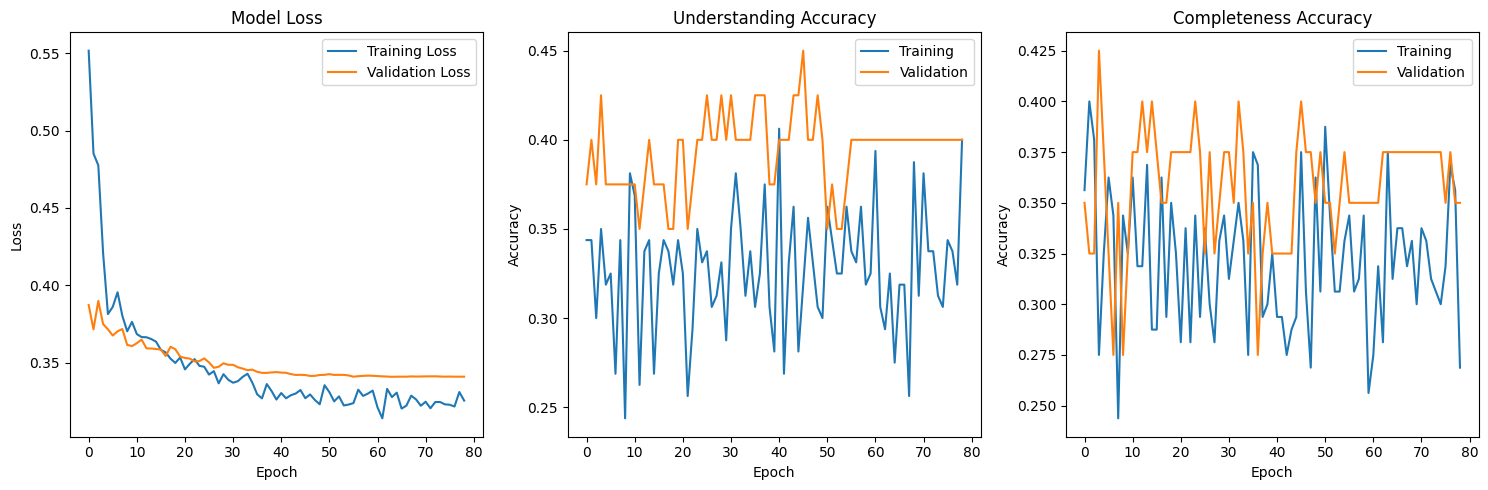

In [34]:
if __name__ == "__main__":
    model, history = main()

In [35]:
model.save('similarity_model.h5')

In [37]:
from typing import Dict

class QuestionEvaluator:
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
    
    def prepare_input_data(self, student_explanation: str, reference_pdf_path: str) -> Dict[str, np.ndarray]:
        # Clean and process texts
        cleaned_explanation = self.processor.clean_text(student_explanation)
        reference_text = self.processor.extract_from_pdf(reference_pdf_path)
        cleaned_reference = self.processor.clean_text(reference_text)
        
        # Generate embeddings
        explanation_emb = self.processor.generate_embeddings(cleaned_explanation)
        reference_emb = self.processor.generate_embeddings(cleaned_reference)
        
        # Convert to numpy
        explanation_emb_np = explanation_emb.cpu().numpy() if torch.cuda.is_available() else explanation_emb.numpy()
        reference_emb_np = reference_emb.cpu().numpy() if torch.cuda.is_available() else reference_emb.numpy()
        
        # Ensure correct shape for model input
        if len(explanation_emb_np.shape) == 1:
            explanation_emb_np = np.expand_dims(explanation_emb_np, 0)
        if len(reference_emb_np.shape) == 1:
            reference_emb_np = np.expand_dims(reference_emb_np, 0)
            
        # Split embeddings
        half_dim = explanation_emb_np.shape[1] // 2
        return {
            "text_input": reference_emb_np[:, :half_dim],
            "explanation_input": explanation_emb_np[:, half_dim:]
        }
    
    def evaluate_explanation(self, student_explanation: str, reference_pdf_path: str) -> Dict[str, Dict[str, float]]:
        input_data = self.prepare_input_data(student_explanation, reference_pdf_path)
        
        # Get predictions using model's predict method
        predictions = self.model.model.predict([
            input_data['text_input'],
            input_data['explanation_input']
        ])
        
        # Convert predictions to probabilities
        understanding_pred = predictions[0]
        completeness_pred = predictions[1]
        
        # Format results with confidence scores
        results = {
            "understanding": {
                "Low": float(understanding_pred[0][0]),
                "Medium": float(understanding_pred[0][1]), 
                "High": float(understanding_pred[0][2])
            },
            "completeness": {
                "Incomplete": float(completeness_pred[0][0]),
                "Partial": float(completeness_pred[0][1]),
                "Complete": float(completeness_pred[0][2])
            },
            "metrics": {
                "understanding_confidence": float(np.max(understanding_pred)),
                "completeness_confidence": float(np.max(completeness_pred))
            }
        }
        
        return results
    
    def bulk_evaluate(self, explanations_dir: str, references_dir: str) -> List[Dict]:
        evaluation_results = []
        
        txt_files = [f for f in os.listdir(explanations_dir) if f.endswith('.txt')]
        pdf_files = [f for f in os.listdir(references_dir) if f.endswith('.pdf')]
        
        for txt_file in txt_files:
            base_name = os.path.splitext(txt_file)[0]
            matching_pdf = f"{base_name}.pdf"  # Changed from .txt to .pdf
            
            if matching_pdf in pdf_files:
                txt_path = os.path.join(explanations_dir, txt_file)
                pdf_path = os.path.join(references_dir, matching_pdf)
                
                with open(txt_path, 'r', encoding='utf-8') as f:
                    student_explanation = f.read()
                
                try:
                    result = self.evaluate_explanation(student_explanation, pdf_path)
                    result['filename'] = txt_file
                    evaluation_results.append(result)
                except Exception as e:
                    print(f"Error evaluating {txt_file}: {e}")
        
        return evaluation_results

def visualize_evaluation_results(results: List[Dict]):
    """Enhanced visualization with confidence metrics"""
    plt.figure(figsize=(15, 5))
    
    # Understanding scores
    plt.subplot(1, 3, 1)
    understanding_scores = [r['understanding']['High'] for r in results]
    plt.hist(understanding_scores, bins=10, color='blue', alpha=0.7)
    plt.title('Understanding Scores')
    plt.xlabel('High Understanding Probability')
    plt.ylabel('Frequency')
    
    # Completeness scores
    plt.subplot(1, 3, 2)
    completeness_scores = [r['completeness']['Complete'] for r in results]
    plt.hist(completeness_scores, bins=10, color='green', alpha=0.7)
    plt.title('Completeness Scores')
    plt.xlabel('Complete Score Probability')
    plt.ylabel('Frequency')
    
    # Confidence metrics
    plt.subplot(1, 3, 3)
    confidence_u = [r['metrics']['understanding_confidence'] for r in results]
    confidence_c = [r['metrics']['completeness_confidence'] for r in results]
    plt.boxplot([confidence_u, confidence_c], labels=['Understanding', 'Completeness'])
    plt.title('Prediction Confidence')
    plt.ylabel('Confidence Score')
    
    plt.tight_layout()
    plt.show()

In [38]:
def setup_evaluator(model_path=None):
    """
    Set up the QuestionEvaluator with a trained model
    
    Args:
        model_path (str, optional): Path to saved model weights
    
    Returns:
        QuestionEvaluator instance
    """
    # Initialize processor and model
    processor = TextProcessorWithPyMuPDF()
    model = FeynMindModelV2()
    
    # Load pre-trained weights if path provided
    if model_path and os.path.exists(model_path):
        model.model.load_weights(model_path)
    
    # Create evaluator
    evaluator = QuestionEvaluator(model, processor)
    
    return evaluator

def main_evaluation():
    """
    Main function to demonstrate evaluation process
    """
    # Set up evaluator
    evaluator = setup_evaluator()
    
    # Example usage for single explanation
    student_explanation = "Pada bab *Menjelajah Sel*, terdapat beberapa poin penting yang perlu dipahami. Pada *Aktivitas 1.1*, objek yang tidak dapat diamati dengan mikroskop cahaya meliputi virus T2 fag, protein, lipid, molekul-molekul kecil, dan atom. Sebaliknya, objek yang dapat diamati mencakup telur ikan, burung kolibri, manusia, paus biru, dan pohon pinus raksasa. Pada *Aktivitas 1.2*, saya membaca artikel berjudul *Pemeriksaan Sitologi Aspiratif untuk Mendeteksi Kanker Paru*. Artikel ini menjelaskan bahwa para peneliti menggunakan berbagai metode dalam penelitian sitologi untuk mendukung deteksi kanker paru.  Pada *Aktivitas 1.3*, jenis-jenis mikroskop juga dipelajari. Mikroskop cahaya mampu memperbesar hingga 1.000 kali, sementara mikroskop elektron memiliki kemampuan hingga 1.000.000 kali. Namun, perbesaran maksimal pada mikroskop elektron sering kali sulit tercapai karena berbagai faktor teknis. Di *Aktivitas 1.4*, kita mengenal bagian-bagian mikroskop dan fungsinya. Misalnya, lensa okuler berfungsi memperbesar bayangan dari lensa objektif, tabung menghubungkan kedua lensa tersebut, sementara sekrup pengarah kasar dan halus digunakan untuk mengatur fokus dengan tingkat kecepatan yang berbeda. Ada juga revolver yang digunakan untuk mengganti perbesaran lensa objektif, serta meja benda yang menjadi tempat meletakkan preparat.  Selanjutnya, pada *Aktivitas 1.7*, dibahas enam jenis sel yang mendukung retina mata, yaitu sel fotoreseptor, sel bipolar, sel ganglion retina, sel horizontal, sel amakrin, dan sel pigmen retina. Masing-masing sel memiliki peran khusus dalam memastikan fungsi retina berjalan optimal. Selain itu, penting untuk memahami cara memegang, menyimpan, dan menggunakan mikroskop dengan benar. Mikroskop sebaiknya dipegang dengan tangan kanan pada bagian pegangan, sementara tangan kiri menopang di bawahnya, dan disimpan di tempat yang aman serta kering untuk menjaga keawetannya. Demikian penjelasan mengenai materi ini."
    reference_pdf_path = "Perkategori/Biologi-BG-KLS-XI-29-50.pdf"
    
    single_result = evaluator.evaluate_explanation(
        student_explanation, 
        reference_pdf_path
    )
    print("Single Explanation Evaluation:")
    print(single_result)
    
    # Bulk evaluation
    bulk_results = evaluator.bulk_evaluate(
        explanations_dir="Penjelasan/", 
        references_dir="Perkategori/"
    )
    print("\nBulk Evaluation Results:")
    for result in bulk_results:
        print(result)

# Optional: Add visualization for results
def visualize_evaluation_results(results):
    """
    Visualize evaluation results
    
    Args:
        results (List[Dict]): Evaluation results from bulk_evaluate
    """
    import matplotlib.pyplot as plt
    
    understanding_scores = [
        result['understanding']['High'] for result in results
    ]
    completeness_scores = [
        result['completeness']['Complete'] for result in results
    ]
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(understanding_scores, bins=10, color='blue', alpha=0.7)
    plt.title('Distribution of Understanding Scores')
    plt.xlabel('High Understanding Probability')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(completeness_scores, bins=10, color='green', alpha=0.7)
    plt.title('Distribution of Completeness Scores')
    plt.xlabel('Complete Explanation Probability')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [39]:

if __name__ == "__main__":
    main_evaluation()

c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'explanation_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
Single Explanation Evaluation:
{'understanding': {'Low': 0.41907426714897156, 'Medium': 0.4083763659000397, 'High': 0.17254933714866638}, 'completeness': {'Incomplete': 0.21002614498138428, 'Partial': 0.29995042085647583, 'Complete': 0.4900234639644623}, 'metrics': {'understanding_confidence': 0.41907426714897156, 'completeness_confidence': 0.4900234639644623}}

Bulk Evaluation Results:
